# Neural Network Approximation with Standard and Random Activations

This notebook demonstrates approximating a complicated function using TensorFlow. We will compare a standard ReLU network against a network that utilizes random activation functions in its layers. Finally, we will analyze the weights to see which activation functions the model found most useful.

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Define a Complicated Function

We will define a function $f(x)$ involving $\sin$, $\cos$, and $e$.

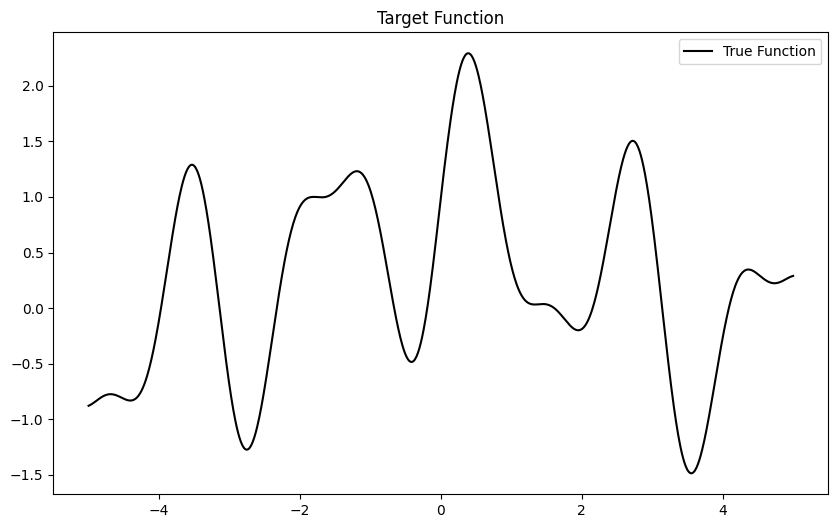

In [26]:
def complex_function(x):
    # Combination of sinusoidal and exponential components
    return np.sin(3 * x) + np.cos(0.5 * x) * np.exp(-0.2 * np.abs(x)) + 0.5 * np.sin(5 * x)

# Generate data
X = np.linspace(-5, 5, 1000).reshape(-1, 1)
y = complex_function(X)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(X, y, label='True Function', color='black')
plt.title("Target Function")
plt.legend()
plt.show()

## 2. Standard Neural Network (ReLU)

Approximating the function using a standard MLP with ReLU activations.

Training Standard Model...
Done.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


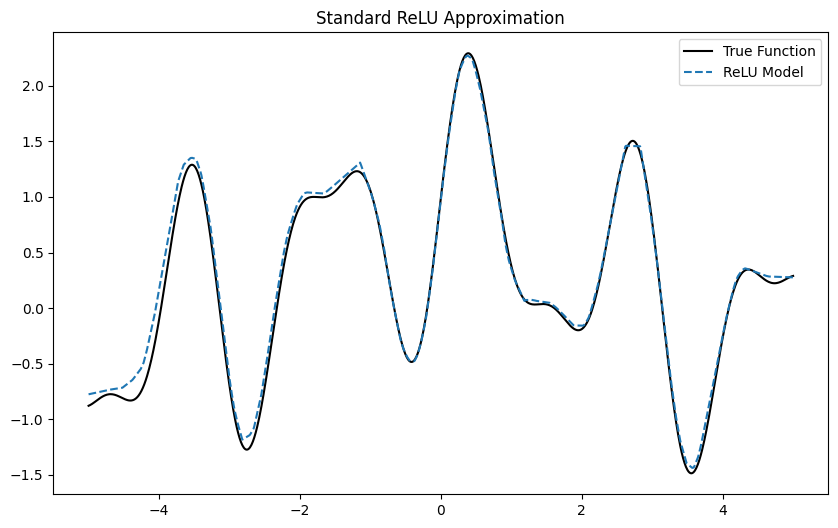

In [27]:
model_std = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_std.compile(optimizer='adam', loss='mse')

print("Training Standard Model...")
history_std = model_std.fit(X, y, epochs=200, batch_size=32, verbose=0)
print("Done.")

y_pred_std = model_std.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='True Function', color='black')
plt.plot(X, y_pred_std, label='ReLU Model', linestyle='--')
plt.title("Standard ReLU Approximation")
plt.legend()
plt.show()

## 3. Neural Network with Random Activation Functions

Here we construct a model where the hidden layer is composed of multiple sub-layers, each using a randomly selected activation function (including sin, cos, etc.).

Training Random Activation Model...
Done.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


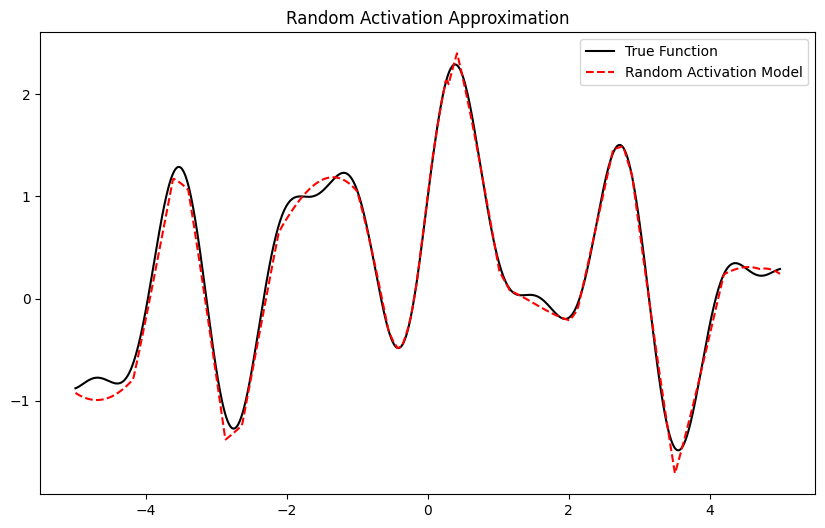

In [28]:
def sin_activation(x):
    return tf.math.sin(x)

def cos_activation(x):
    return tf.math.cos(x)

def build_random_activation_model(input_shape, num_branches=20, units_per_branch=10):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Pool of possible activations
    possible_activations = ['relu', 'tanh', 'sigmoid', 'elu', 'softplus', sin_activation, cos_activation]
    
    branches = []
    activation_names = []
    
    for i in range(num_branches):
        # Randomly select an activation for this branch
        act = np.random.choice(possible_activations)
        
        # Store name for analysis later
        if callable(act):
            name = act.__name__
        else:
            name = act
        activation_names.append(name)
        
        # Create a dense layer with this activation
        # We name it so we can easily identify it if inspecting layers directly
        branch = tf.keras.layers.Dense(units_per_branch, activation=act, name=f'branch_{i}_{name}')(inputs)
        branches.append(branch)
    
    # Concatenate all branches
    concat = tf.keras.layers.Concatenate(name='concat')(branches)
    
    # Additional mixing layers
    # We name the first mixing layer to retrieve its weights easily
    hidden = tf.keras.layers.Dense(64, activation='relu', name='mixing_layer')(concat)
    output = tf.keras.layers.Dense(1)(hidden)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    # Attach metadata to the model object for convenience
    model.activation_list = activation_names
    model.units_per_branch = units_per_branch
    return model

model_random = build_random_activation_model((1,), num_branches=30, units_per_branch=5)
model_random.compile(optimizer='adam', loss='mse')

print("Training Random Activation Model...")
history_rand = model_random.fit(X, y, epochs=200, batch_size=32, verbose=0)
print("Done.")

y_pred_rand = model_random.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='True Function', color='black')
plt.plot(X, y_pred_rand, label='Random Activation Model', color='red', linestyle='--')
plt.title("Random Activation Approximation")
plt.legend()
plt.show()

## 4. Comparison

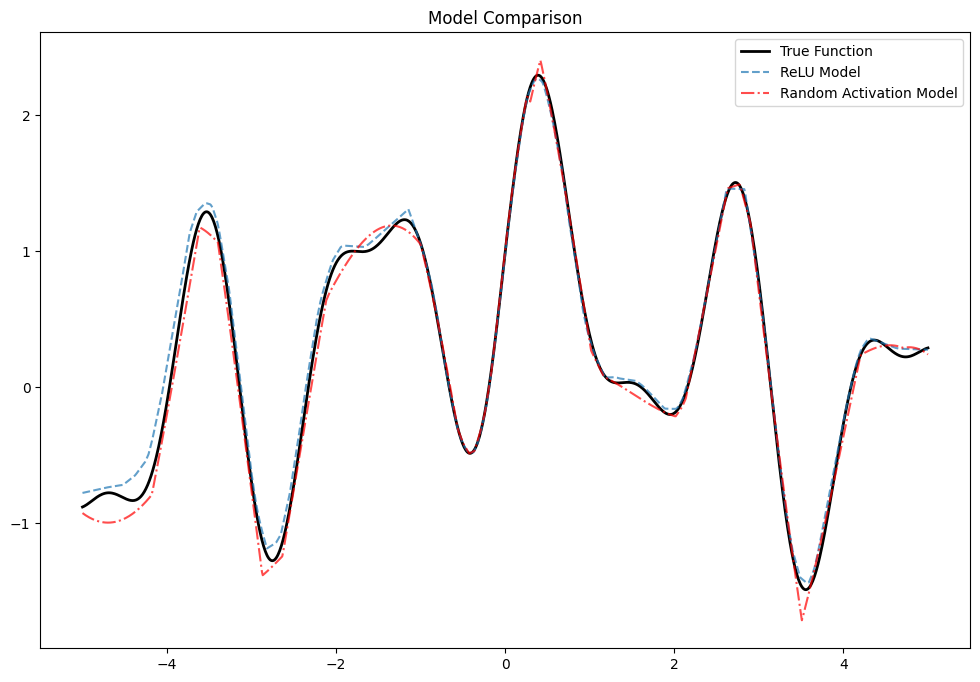

Final Loss (ReLU): 0.004566
Final Loss (Random): 0.005248


In [29]:
plt.figure(figsize=(12, 8))
plt.plot(X, y, label='True Function', color='black', linewidth=2)
plt.plot(X, y_pred_std, label='ReLU Model', linestyle='--', alpha=0.7)
plt.plot(X, y_pred_rand, label='Random Activation Model', linestyle='-.', color='red', alpha=0.7)
plt.title("Model Comparison")
plt.legend()
plt.show()

print(f"Final Loss (ReLU): {history_std.history['loss'][-1]:.6f}")
print(f"Final Loss (Random): {history_rand.history['loss'][-1]:.6f}")

## 5. Weight Analysis

We analyze the weights of the `mixing_layer` to determine which activation functions contributed most to the final output. The `mixing_layer` takes the concatenated output of all branches as input. By looking at the magnitude of weights connected to each branch, we can infer importance.

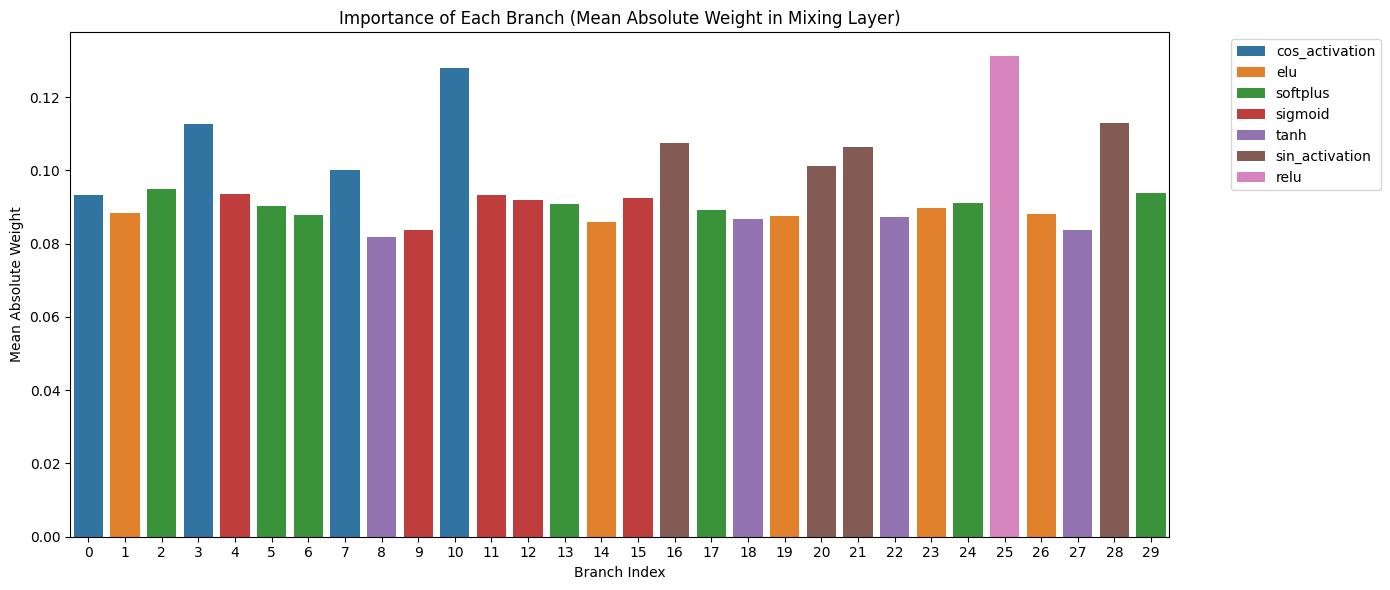

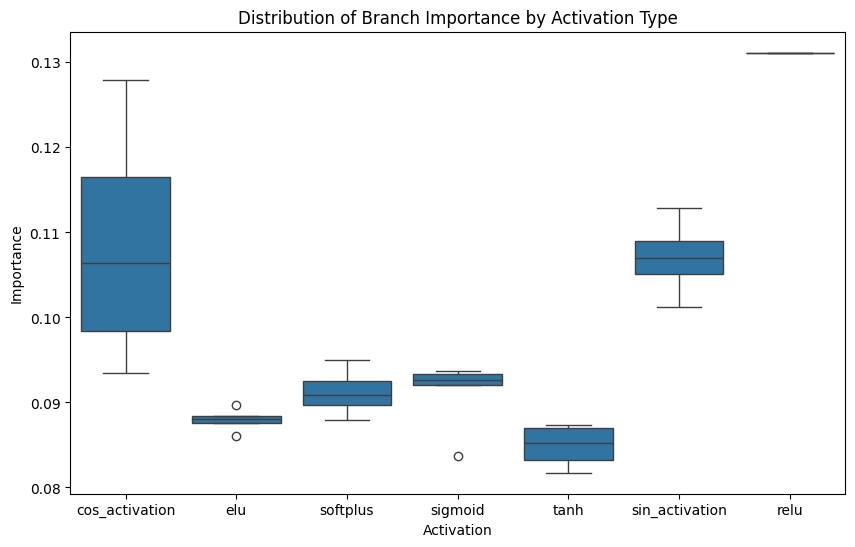

Average Importance by Activation Type:
Activation
relu              0.131128
cos_activation    0.108551
sin_activation    0.107043
softplus          0.091187
sigmoid           0.091060
elu               0.087931
tanh              0.084905
Name: Importance, dtype: float32


In [30]:
# 1. Retrieve weights from the mixing layer
mixing_layer = model_random.get_layer('mixing_layer')
weights, biases = mixing_layer.get_weights()
# weights shape: (num_branches * units_per_branch, 64)

num_branches = len(model_random.activation_list)
units_per_branch = model_random.units_per_branch

# 2. Reshape weights to separate branches
# New shape: (num_branches, units_per_branch, 64)
weights_reshaped = weights.reshape(num_branches, units_per_branch, -1)

# 3. Calculate "importance" score for each branch
# We can take the mean absolute value of weights originating from each branch
branch_importance = np.mean(np.abs(weights_reshaped), axis=(1, 2))

# 4. Create a DataFrame for visualization
df_importance = pd.DataFrame({
    'Activation': model_random.activation_list,
    'Importance': branch_importance,
    'Branch_Index': range(num_branches)
})

# 5. Plot Importance per Branch (colored by activation)
plt.figure(figsize=(14, 6))
sns.barplot(data=df_importance, x='Branch_Index', y='Importance', hue='Activation', dodge=False)
plt.title("Importance of Each Branch (Mean Absolute Weight in Mixing Layer)")
plt.xlabel("Branch Index")
plt.ylabel("Mean Absolute Weight")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Aggregated Importance by Activation Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_importance, x='Activation', y='Importance')
plt.title("Distribution of Branch Importance by Activation Type")
plt.show()

# 7. Average Importance by Activation Type
avg_importance = df_importance.groupby('Activation')['Importance'].mean().sort_values(ascending=False)
print("Average Importance by Activation Type:")
print(avg_importance)

### Weight Histograms

Let's look at the distribution of weights *inside* the branches for different activation functions.

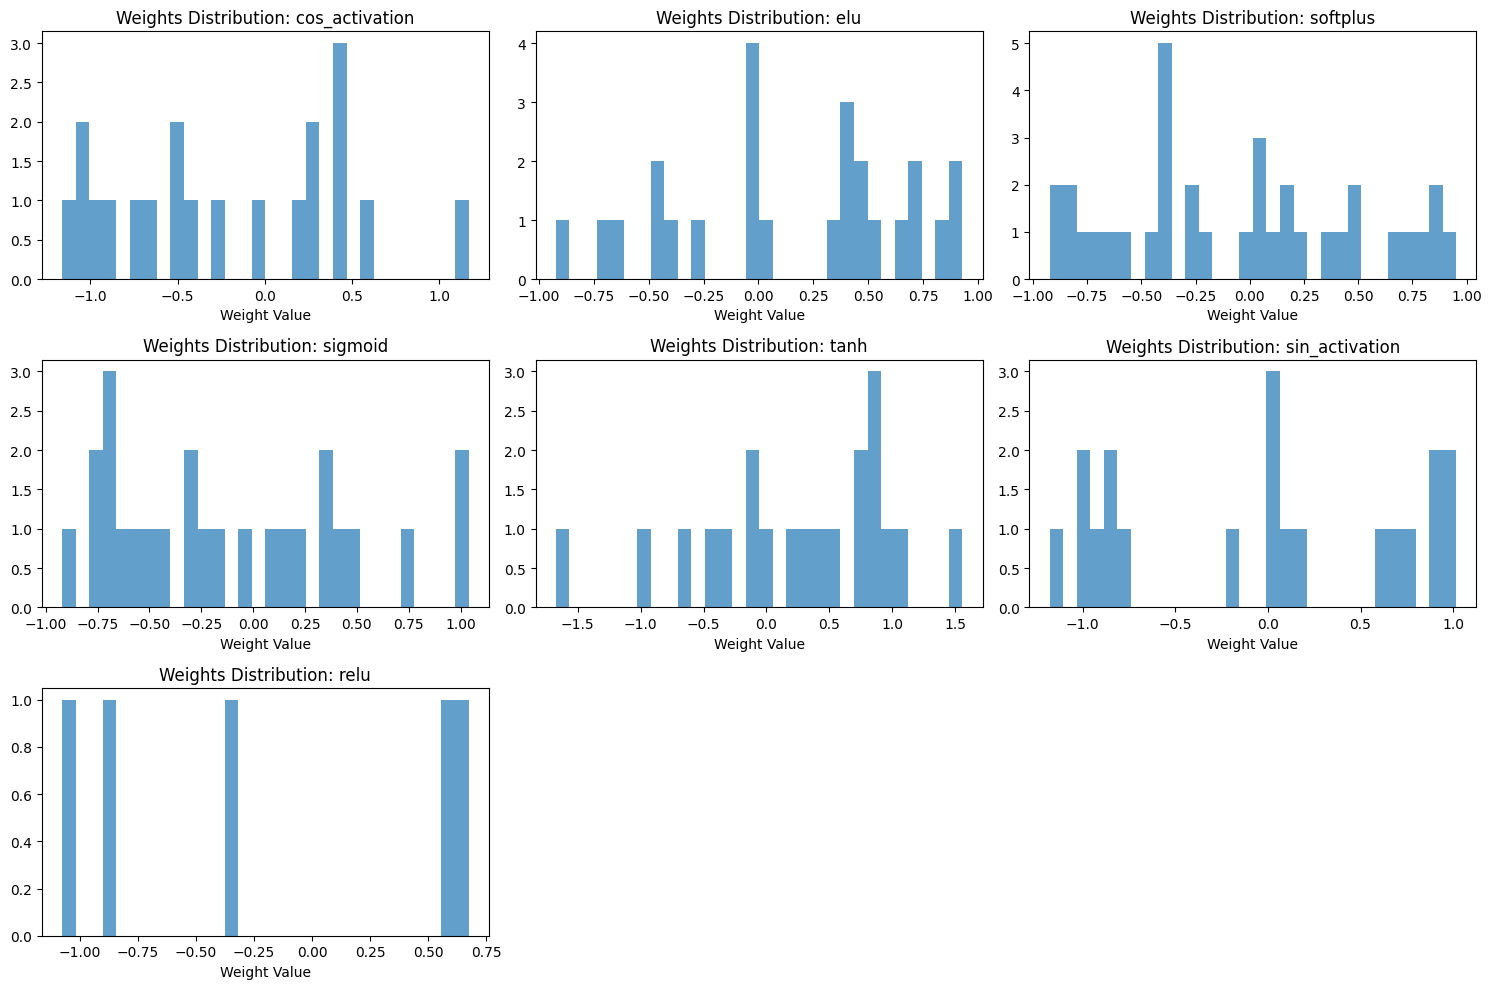

In [31]:
plt.figure(figsize=(15, 10))

activations_present = df_importance['Activation'].unique()

for i, act_name in enumerate(activations_present):
    # Collect weights from all branches with this activation
    all_weights = []
    for branch_idx, name in enumerate(model_random.activation_list):
        if name == act_name:
            # Get the specific layer
            layer_name = f'branch_{branch_idx}_{name}'
            layer = model_random.get_layer(layer_name)
            w, b = layer.get_weights()
            all_weights.extend(w.flatten())
            
    plt.subplot(3, 3, i+1)
    plt.hist(all_weights, bins=30, alpha=0.7)
    plt.title(f'Weights Distribution: {act_name}')
    plt.xlabel('Weight Value')

plt.tight_layout()
plt.show()